# ResNet

## Import Libraries
Fungsi: Mengimport semua library yang dibutuhkan untuk project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import warnings
import copy
warnings.filterwarnings('ignore')


## Configuration & Constants
Fungsi: Mendefinisikan semua parameter dan konfigurasi training

In [3]:
DATA_DIR = '/kaggle/input/eye-diseases-classification/dataset'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
RANDOM_STATE = 42
NUM_CLASSES = 4

CATEGORIES = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print("Configuration loaded successfully!")
print(f"Categories: {CATEGORIES}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Configuration loaded successfully!
Categories: ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']
Image size: 224x224
Batch size: 32


## Custom Dataset Class
Fungsi: Membuat custom dataset class untuk PyTorch

In [4]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("EyeDataset class defined successfully!")


EyeDataset class defined successfully!


## Data Loading Functions
Fungsi: Fungsi untuk load dan split dataset

In [5]:
def load_dataset(data_dir):
    """Load semua gambar dan label dari direktori"""
    image_paths = []
    labels = []
    
    for idx, category in enumerate(CATEGORIES):
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(idx)
    
    return image_paths, labels

def split_dataset(image_paths, labels, train_ratio=0.7, val_ratio=0.15):
    """Split dataset menjadi train, validation, dan test"""
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, train_size=train_ratio, 
        random_state=RANDOM_STATE, stratify=labels
    )
    
    val_size = val_ratio / (1 - train_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, train_size=val_size, 
        random_state=RANDOM_STATE, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


## Data Augmentation & Transforms
Fungsi: Mendefinisikan transformasi untuk preprocessing dan augmentasi

In [6]:
def get_transforms():
    """Define transforms untuk training dan validation/testing"""
    
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_test_transform

print("Data transforms defined successfully!")


Data transforms defined successfully!


## Model Architecture
Fungsi: Membuat model ResNet50 dengan pretrained weights

In [7]:
def create_resnet_model(num_classes=4, pretrained=True):
    """Create ResNet50 model untuk klasifikasi"""
    model = models.resnet50(pretrained=pretrained)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

print("Model architecture function defined successfully!")


Model architecture function defined successfully!


## Training Function
Fungsi: Fungsi utama untuk training model

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, scheduler=None):
    """Training loop untuk model"""
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        train_bar = tqdm(train_loader, desc='Training')
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        val_bar = tqdm(val_loader, desc='Validation')
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')
        
        if scheduler:
            scheduler.step()
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'✓ Best model updated! Accuracy: {best_acc:.4f}')
    
    print('\n' + '='*60)
    print(f'Training Complete! Best Validation Accuracy: {best_acc:.4f}')
    print('='*60)
    
    model.load_state_dict(best_model_wts)
    return model, history

print("Training function defined successfully!")


Training function defined successfully!


## Evaluation Function
Fungsi: Evaluasi model pada test set

In [9]:
def evaluate_model(model, test_loader, device):
    """Evaluate model pada test set"""
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                   target_names=CATEGORIES)
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, report, cm, all_preds, all_labels

print("Evaluation function defined successfully!")


Evaluation function defined successfully!


## Visualization Functions
Fungsi: Membuat visualisasi hasil training dan evaluasi

In [10]:
def plot_training_history(history):
    """Plot training dan validation loss/accuracy"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
    ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("Training history saved as 'training_history.png'")
    plt.show()

def plot_confusion_matrix(cm, accuracy):
    """Plot confusion matrix"""
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=CATEGORIES,
               yticklabels=CATEGORIES,
               cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix\nTest Accuracy: {accuracy:.4f}', 
             fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Confusion matrix saved as 'confusion_matrix.png'")
    plt.show()

print("Visualization functions defined successfully!")


Visualization functions defined successfully!


## Load and Prepare Dataset
Load dataset dan split menjadi train/val/test

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n" + "="*60)
print("LOADING DATASET")
print("="*60)

image_paths, labels = load_dataset(DATA_DIR)
print(f"\nTotal images: {len(image_paths)}")

unique, counts = np.unique(labels, return_counts=True)
print("\nDataset distribution:")
for cat_idx, count in zip(unique, counts):
    print(f"  {CATEGORIES[cat_idx]}: {count}")

X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(
    image_paths, labels
)
print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


Using device: cuda
GPU: Tesla T4

LOADING DATASET

Total images: 4217

Dataset distribution:
  normal: 1074
  cataract: 1038
  glaucoma: 1007
  diabetic_retinopathy: 1098

Training samples: 2951
Validation samples: 632
Testing samples: 634


## Create DataLoaders
Membuat DataLoader untuk efficient batch processing

In [12]:
print("\n" + "="*60)
print("CREATING DATALOADERS")
print("="*60)

train_transform, val_test_transform = get_transforms()

train_dataset = EyeDataset(X_train, y_train, train_transform)
val_dataset = EyeDataset(X_val, y_val, val_test_transform)
test_dataset = EyeDataset(X_test, y_test, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                       shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



CREATING DATALOADERS
Train batches: 93
Validation batches: 20
Test batches: 20


## Initialize Model
Membuat dan setup model untuk training

In [13]:
print("\n" + "="*60)
print("INITIALIZING MODEL")
print("="*60)

model = create_resnet_model(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(model)
print("\nModel initialized successfully!")



INITIALIZING MODEL


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]



Total parameters: 23,516,228
Trainable parameters: 23,516,228
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequentia

## Train Model
Menjalankan training process

In [14]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    NUM_EPOCHS, device, scheduler
)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, 'resnet50_eye_disease.pth')

print("\nModel saved as 'resnet50_eye_disease.pth'")



STARTING TRAINING

Epoch 1/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:29<00:00,  3.13it/s, loss=0.733]


Train Loss: 0.7998 | Train Acc: 0.6886


Validation: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s, loss=0.911]


Val Loss: 0.9816 | Val Acc: 0.6329
✓ Best model updated! Accuracy: 0.6329

Epoch 2/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:28<00:00,  3.22it/s, loss=0.866]


Train Loss: 0.6200 | Train Acc: 0.7594


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.839]


Val Loss: 0.6882 | Val Acc: 0.7358
✓ Best model updated! Accuracy: 0.7358

Epoch 3/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:31<00:00,  2.99it/s, loss=0.279]


Train Loss: 0.5907 | Train Acc: 0.7733


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.801]


Val Loss: 0.7790 | Val Acc: 0.7310

Epoch 4/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s, loss=0.694]


Train Loss: 0.5120 | Train Acc: 0.8052


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s, loss=1.05] 


Val Loss: 1.0021 | Val Acc: 0.6203

Epoch 5/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:32<00:00,  2.84it/s, loss=0.221]


Train Loss: 0.4629 | Train Acc: 0.8207


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.649]


Val Loss: 0.4941 | Val Acc: 0.8117
✓ Best model updated! Accuracy: 0.8117

Epoch 6/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=1.24] 


Train Loss: 0.4066 | Train Acc: 0.8485


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, loss=0.788]


Val Loss: 0.6841 | Val Acc: 0.7500

Epoch 7/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.466]


Train Loss: 0.3687 | Train Acc: 0.8624


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.565]


Val Loss: 0.5837 | Val Acc: 0.7864

Epoch 8/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.82it/s, loss=0.09]  


Train Loss: 0.3442 | Train Acc: 0.8750


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss=0.495]


Val Loss: 0.3938 | Val Acc: 0.8418
✓ Best model updated! Accuracy: 0.8418

Epoch 9/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=1.03]  


Train Loss: 0.3338 | Train Acc: 0.8787


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s, loss=0.553]


Val Loss: 0.4460 | Val Acc: 0.8275

Epoch 10/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.426] 


Train Loss: 0.3181 | Train Acc: 0.8855


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss=0.693]


Val Loss: 0.5409 | Val Acc: 0.8070

Epoch 11/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.164] 


Train Loss: 0.2470 | Train Acc: 0.9116


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.523] 


Val Loss: 0.3319 | Val Acc: 0.8671
✓ Best model updated! Accuracy: 0.8671

Epoch 12/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.495] 


Train Loss: 0.2284 | Train Acc: 0.9197


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.515] 


Val Loss: 0.3054 | Val Acc: 0.8877
✓ Best model updated! Accuracy: 0.8877

Epoch 13/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.75it/s, loss=0.487] 


Train Loss: 0.2166 | Train Acc: 0.9241


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, loss=0.537] 


Val Loss: 0.3119 | Val Acc: 0.8877

Epoch 14/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.81it/s, loss=0.312] 


Train Loss: 0.2062 | Train Acc: 0.9275


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.47]  


Val Loss: 0.3032 | Val Acc: 0.8892
✓ Best model updated! Accuracy: 0.8892

Epoch 15/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.75it/s, loss=1.85]  


Train Loss: 0.2001 | Train Acc: 0.9238


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.384] 


Val Loss: 0.2792 | Val Acc: 0.9051
✓ Best model updated! Accuracy: 0.9051

Epoch 16/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.21]  


Train Loss: 0.2082 | Train Acc: 0.9214


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.488] 


Val Loss: 0.3079 | Val Acc: 0.8892

Epoch 17/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:34<00:00,  2.73it/s, loss=0.072] 


Train Loss: 0.1969 | Train Acc: 0.9282


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, loss=0.512] 


Val Loss: 0.3263 | Val Acc: 0.8782

Epoch 18/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.127] 


Train Loss: 0.1863 | Train Acc: 0.9309


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.492] 


Val Loss: 0.3154 | Val Acc: 0.8892

Epoch 19/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.0163]


Train Loss: 0.1858 | Train Acc: 0.9288


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.49]  


Val Loss: 0.3019 | Val Acc: 0.8924

Epoch 20/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.0951]


Train Loss: 0.1891 | Train Acc: 0.9332


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.47]  


Val Loss: 0.2853 | Val Acc: 0.9035

Epoch 21/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.309] 


Train Loss: 0.1800 | Train Acc: 0.9343


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.442] 


Val Loss: 0.2755 | Val Acc: 0.8987

Epoch 22/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=0.0625]


Train Loss: 0.1730 | Train Acc: 0.9346


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.463] 


Val Loss: 0.3032 | Val Acc: 0.8956

Epoch 23/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=0.0337]


Train Loss: 0.1728 | Train Acc: 0.9373


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.453] 


Val Loss: 0.2929 | Val Acc: 0.9035

Epoch 24/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.354] 


Train Loss: 0.1781 | Train Acc: 0.9363


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.458] 


Val Loss: 0.2948 | Val Acc: 0.8956

Epoch 25/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.024] 


Train Loss: 0.1614 | Train Acc: 0.9373


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss=0.421] 


Val Loss: 0.2724 | Val Acc: 0.9035

Epoch 26/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.0485]


Train Loss: 0.1631 | Train Acc: 0.9431


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.473] 


Val Loss: 0.2956 | Val Acc: 0.9019

Epoch 27/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.0354]


Train Loss: 0.1718 | Train Acc: 0.9360


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.462] 


Val Loss: 0.2908 | Val Acc: 0.8987

Epoch 28/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.309] 


Train Loss: 0.1630 | Train Acc: 0.9380


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.446] 


Val Loss: 0.2742 | Val Acc: 0.8972

Epoch 29/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.107] 


Train Loss: 0.1579 | Train Acc: 0.9397


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.439] 


Val Loss: 0.2743 | Val Acc: 0.9019

Epoch 30/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.81it/s, loss=0.043] 


Train Loss: 0.1657 | Train Acc: 0.9329


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s, loss=0.435] 


Val Loss: 0.2807 | Val Acc: 0.9051

Epoch 31/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=0.165] 


Train Loss: 0.1602 | Train Acc: 0.9417


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss=0.43]  


Val Loss: 0.2770 | Val Acc: 0.9098
✓ Best model updated! Accuracy: 0.9098

Epoch 32/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.0698]


Train Loss: 0.1567 | Train Acc: 0.9444


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.45]  


Val Loss: 0.2925 | Val Acc: 0.9051

Epoch 33/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.384] 


Train Loss: 0.1628 | Train Acc: 0.9427


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.422] 


Val Loss: 0.2684 | Val Acc: 0.9066

Epoch 34/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.0276]


Train Loss: 0.1601 | Train Acc: 0.9400


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.479] 


Val Loss: 0.2945 | Val Acc: 0.9019

Epoch 35/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.0992]


Train Loss: 0.1576 | Train Acc: 0.9454


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss=0.446] 


Val Loss: 0.2804 | Val Acc: 0.9019

Epoch 36/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.0363]


Train Loss: 0.1703 | Train Acc: 0.9349


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.442] 


Val Loss: 0.2777 | Val Acc: 0.9051

Epoch 37/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.82it/s, loss=0.0284]


Train Loss: 0.1648 | Train Acc: 0.9339


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s, loss=0.468] 


Val Loss: 0.2915 | Val Acc: 0.9035

Epoch 38/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=0.248] 


Train Loss: 0.1659 | Train Acc: 0.9370


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s, loss=0.481] 


Val Loss: 0.2875 | Val Acc: 0.8987

Epoch 39/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.712] 


Train Loss: 0.1575 | Train Acc: 0.9421


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, loss=0.444] 


Val Loss: 0.2769 | Val Acc: 0.9019

Epoch 40/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.81it/s, loss=0.341] 


Train Loss: 0.1586 | Train Acc: 0.9417


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s, loss=0.46]  


Val Loss: 0.2842 | Val Acc: 0.9066

Epoch 41/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.77it/s, loss=0.0692]


Train Loss: 0.1711 | Train Acc: 0.9346


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.445] 


Val Loss: 0.2719 | Val Acc: 0.9019

Epoch 42/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.75it/s, loss=0.057] 


Train Loss: 0.1538 | Train Acc: 0.9454


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.469] 


Val Loss: 0.2886 | Val Acc: 0.9051

Epoch 43/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.0457]


Train Loss: 0.1572 | Train Acc: 0.9461


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.458] 


Val Loss: 0.2795 | Val Acc: 0.9003

Epoch 44/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.76it/s, loss=0.14]  


Train Loss: 0.1544 | Train Acc: 0.9414


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.459] 


Val Loss: 0.2875 | Val Acc: 0.9066

Epoch 45/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.0781]


Train Loss: 0.1581 | Train Acc: 0.9417


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.475] 


Val Loss: 0.2887 | Val Acc: 0.8987

Epoch 46/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=0.18]  


Train Loss: 0.1569 | Train Acc: 0.9414


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.456] 


Val Loss: 0.2754 | Val Acc: 0.8987

Epoch 47/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.196] 


Train Loss: 0.1636 | Train Acc: 0.9383


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss=0.435] 


Val Loss: 0.2721 | Val Acc: 0.8956

Epoch 48/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, loss=0.0591]


Train Loss: 0.1580 | Train Acc: 0.9414


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.442] 


Val Loss: 0.2711 | Val Acc: 0.9003

Epoch 49/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.79it/s, loss=1.31]  


Train Loss: 0.1583 | Train Acc: 0.9407


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, loss=0.472]


Val Loss: 0.2873 | Val Acc: 0.9035

Epoch 50/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:33<00:00,  2.80it/s, loss=0.295] 


Train Loss: 0.1551 | Train Acc: 0.9400


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.438] 


Val Loss: 0.2772 | Val Acc: 0.9066

Training Complete! Best Validation Accuracy: 0.9098

Model saved as 'resnet50_eye_disease.pth'


## Evaluate and Visualize Results
Evaluasi final model dan buat visualisasi


EVALUATION & VISUALIZATION

Evaluating on test set...


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]



Test Accuracy: 0.9180

Classification Report:
                      precision    recall  f1-score   support

              normal       0.87      0.86      0.87       161
            cataract       0.96      0.96      0.96       156
            glaucoma       0.85      0.92      0.89       151
diabetic_retinopathy       1.00      0.93      0.96       166

            accuracy                           0.92       634
           macro avg       0.92      0.92      0.92       634
        weighted avg       0.92      0.92      0.92       634

Training history saved as 'training_history.png'


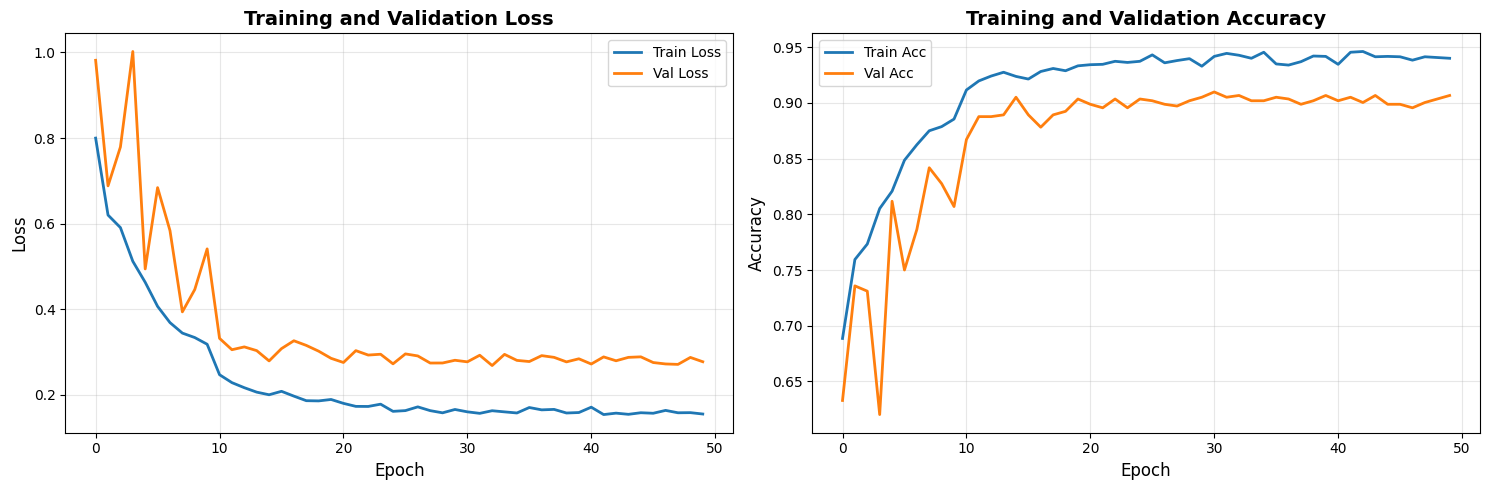

Confusion matrix saved as 'confusion_matrix.png'


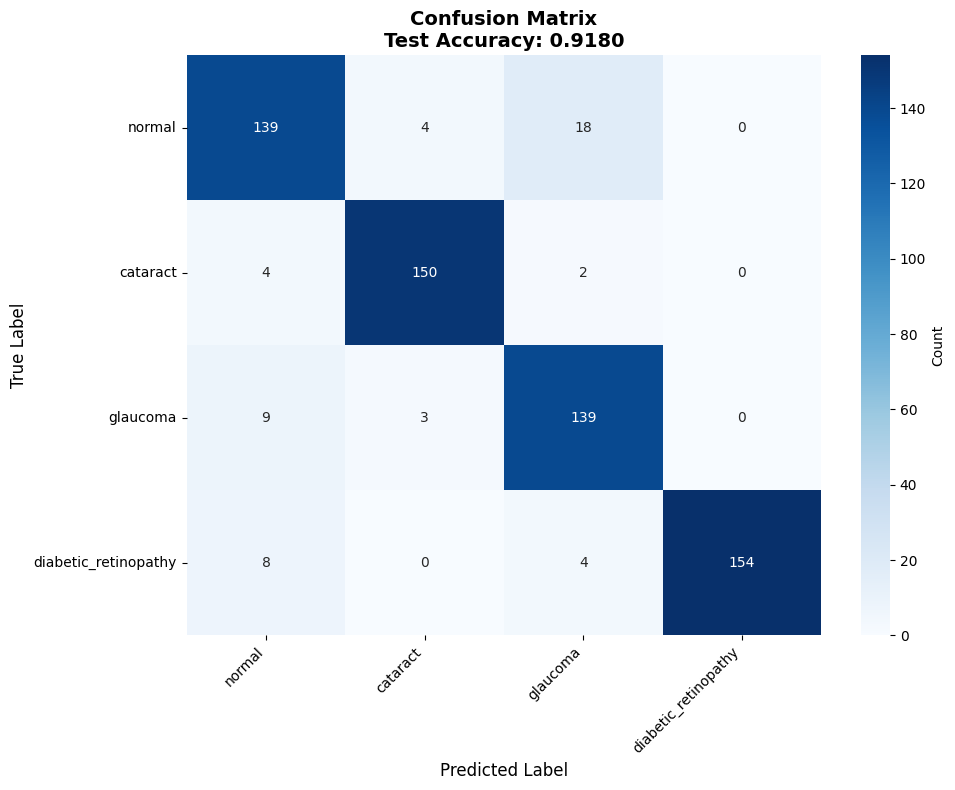


TRAINING COMPLETE!


In [15]:
print("\n" + "="*60)
print("EVALUATION & VISUALIZATION")
print("="*60)

accuracy, report, cm, preds, labels_true = evaluate_model(
    model, test_loader, device
)

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

plot_training_history(history)
plot_confusion_matrix(cm, accuracy)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


# EfficientNet

## Import Libraries
Mengimport semua library yang dibutuhkan untuk project

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import warnings
import copy
import timm  # PyTorch Image Models untuk EfficientNet
warnings.filterwarnings('ignore')

## Configuration & Constants
Mendefinisikan semua parameter dan konfigurasi training

In [17]:
DATA_DIR = '/kaggle/input/eye-diseases-classification/dataset'
IMG_SIZE = 224  # EfficientNet-B0 menggunakan 224x224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
RANDOM_STATE = 42
NUM_CLASSES = 4

# Pilih model EfficientNet (bisa diganti dengan B1-B7)
# Opsi: efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, 
#       efficientnet_b4, efficientnet_b5, efficientnet_b6, efficientnet_b7
EFFICIENTNET_MODEL = 'efficientnet_b3'

# Kategori penyakit
CATEGORIES = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

# Set random seed untuk reproducibility
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Model: {EFFICIENTNET_MODEL}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Categories: {CATEGORIES}")
print("="*60)


CONFIGURATION
Model: efficientnet_b3
Image Size: 224x224
Batch Size: 32
Learning Rate: 0.001
Epochs: 50
Categories: ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']


## Custom Dataset Class
Membuat custom dataset class untuk PyTorch

In [18]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("EyeDataset class defined successfully!")


EyeDataset class defined successfully!


## Data Loading Functions
Fungsi untuk load dan split dataset

In [19]:
def load_dataset(data_dir):
    """Load semua gambar dan label dari direktori"""
    image_paths = []
    labels = []
    
    for idx, category in enumerate(CATEGORIES):
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(idx)
    
    return image_paths, labels

def split_dataset(image_paths, labels, train_ratio=0.7, val_ratio=0.15):
    """Split dataset menjadi train, validation, dan test"""
    # Split train and temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, train_size=train_ratio, 
        random_state=RANDOM_STATE, stratify=labels
    )
    
    # Split temp menjadi val and test
    val_size = val_ratio / (1 - train_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, train_size=val_size, 
        random_state=RANDOM_STATE, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

print("Data loading functions defined successfully!")


Data loading functions defined successfully!


## Data Augmentation & Transforms
Mendefinisikan transformasi untuk preprocessing dan augmentasi

In [20]:
def get_transforms():
    """Define transforms untuk training dan validation/testing"""
    
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_test_transform

print("Data augmentation transforms defined successfully!")
print("Train augmentations: Flip, Rotation, ColorJitter, Affine")
print("Val/Test: Resize + Normalize only")


Data augmentation transforms defined successfully!
Train augmentations: Flip, Rotation, ColorJitter, Affine
Val/Test: Resize + Normalize only


## EfficientNet Model Architecture
Membuat model EfficientNet dengan pretrained weights

In [21]:
def create_efficientnet_model(model_name='efficientnet_b3', num_classes=4, pretrained=True):
    """Create EfficientNet model untuk klasifikasi"""
    
    # Load pretrained EfficientNet menggunakan timm
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    
    print(f"\nModel Architecture: {model_name}")
    print(f"Input size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Output classes: {num_classes}")
    
    return model

print("EfficientNet model creation function defined successfully!")


EfficientNet model creation function defined successfully!


## Training Function
Fungsi utama untuk training model dengan validation

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, scheduler=None):
    """Training loop untuk model"""
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        train_bar = tqdm(train_loader, desc='Training')
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        val_bar = tqdm(val_loader, desc='Validation')
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix({'loss': loss.item()})
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')
        
        # Update learning rate
        if scheduler:
            scheduler.step()
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'✓ Best model updated! Accuracy: {best_acc:.4f}')
    
    print('\n' + '='*60)
    print(f'Training Complete! Best Validation Accuracy: {best_acc:.4f}')
    print('='*60)
    
    model.load_state_dict(best_model_wts)
    return model, history

print("Training function defined successfully!")


Training function defined successfully!


## Evaluation Function
Evaluasi model pada test set

In [23]:
def evaluate_model(model, test_loader, device):
    """Evaluate model pada test set"""
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                   target_names=CATEGORIES)
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, report, cm, all_preds, all_labels, all_probs

print("Evaluation function defined successfully!")


Evaluation function defined successfully!


## Visualization Functions - Training History
Membuat visualisasi training curves

In [24]:
def plot_training_history(history):
    """Plot training dan validation loss/accuracy"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', 
             linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', 
             linewidth=2, marker='s', markersize=4)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc', 
             linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc', 
             linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('efficientnet_training_history.png', dpi=300, bbox_inches='tight')
    print("Training history saved as 'efficientnet_training_history.png'")
    plt.show()

print("Training history visualization function defined!")


Training history visualization function defined!


## Visualization Functions - Confusion Matrix
Membuat heatmap confusion matrix

In [25]:
def plot_confusion_matrix(cm, accuracy):
    """Plot confusion matrix"""
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=CATEGORIES,
               yticklabels=CATEGORIES,
               cbar_kws={'label': 'Count'},
               annot_kws={'size': 14})
    plt.title(f'Confusion Matrix - EfficientNet\nTest Accuracy: {accuracy:.4f}', 
             fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('efficientnet_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Confusion matrix saved as 'efficientnet_confusion_matrix.png'")
    plt.show()

print("Confusion matrix visualization function defined!")


Confusion matrix visualization function defined!


## Visualization Functions - Per-Class Metrics
Membuat bar chart untuk per-class performance metrics

In [26]:
def plot_per_class_metrics(report_dict):
    """Plot per-class precision, recall, f1-score"""
    
    classes = CATEGORIES
    metrics = ['precision', 'recall', 'f1-score']
    
    data = {metric: [report_dict[cls][metric] for cls in classes] for metric in metrics}
    
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width, data['precision'], width, label='Precision', color='#FF6B6B')
    bars2 = ax.bar(x, data['recall'], width, label='Recall', color='#4ECDC4')
    bars3 = ax.bar(x + width, data['f1-score'], width, label='F1-Score', color='#45B7D1')
    
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('efficientnet_per_class_metrics.png', dpi=300, bbox_inches='tight')
    print("Per-class metrics saved as 'efficientnet_per_class_metrics.png'")
    plt.show()

print("Per-class metrics visualization function defined!")


Per-class metrics visualization function defined!


## Load and Prepare Dataset
Load dataset dan split menjadi train/val/test

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*60)
print("SETUP")
print("="*60)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print("\n" + "="*60)
print("LOADING DATASET")
print("="*60)

image_paths, labels = load_dataset(DATA_DIR)
print(f"\nTotal images: {len(image_paths)}")

unique, counts = np.unique(labels, return_counts=True)
print("\nDataset distribution:")
for cat_idx, count in zip(unique, counts):
    percentage = (count / len(labels)) * 100
    print(f"  {CATEGORIES[cat_idx]:25s}: {count:4d} ({percentage:.1f}%)")

X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(
    image_paths, labels
)
print(f"\nData Split:")
print(f"  Training samples:   {len(X_train):4d} (70%)")
print(f"  Validation samples: {len(X_val):4d} (15%)")
print(f"  Testing samples:    {len(X_test):4d} (15%)")


SETUP
Device: cuda
GPU: Tesla T4
GPU Memory: 14.74 GB

LOADING DATASET

Total images: 4217

Dataset distribution:
  normal                   : 1074 (25.5%)
  cataract                 : 1038 (24.6%)
  glaucoma                 : 1007 (23.9%)
  diabetic_retinopathy     : 1098 (26.0%)

Data Split:
  Training samples:   2951 (70%)
  Validation samples:  632 (15%)
  Testing samples:     634 (15%)


## Create DataLoaders
Membuat DataLoader untuk efficient batch processing

In [28]:
print("\n" + "="*60)
print("CREATING DATALOADERS")
print("="*60)

train_transform, val_test_transform = get_transforms()

train_dataset = EyeDataset(X_train, y_train, train_transform)
val_dataset = EyeDataset(X_val, y_val, val_test_transform)
test_dataset = EyeDataset(X_test, y_test, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                       shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=4, pin_memory=True)

print(f"\nDataLoader Info:")
print(f"  Train batches:      {len(train_loader):4d} batches")
print(f"  Validation batches: {len(val_loader):4d} batches")
print(f"  Test batches:       {len(test_loader):4d} batches")
print(f"  Batch size:         {BATCH_SIZE}")



CREATING DATALOADERS

DataLoader Info:
  Train batches:        93 batches
  Validation batches:   20 batches
  Test batches:         20 batches
  Batch size:         32


## Initialize Model and Training Setup
Membuat dan setup model untuk training

In [29]:
print("\n" + "="*60)
print("INITIALIZING MODEL")
print("="*60)

model = create_efficientnet_model(model_name=EFFICIENTNET_MODEL, 
                                 num_classes=NUM_CLASSES, 
                                 pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total parameters:      {total_params:,}")
print(f"  Trainable parameters:  {trainable_params:,}")

# Setup training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                 factor=0.5, patience=5, 
                                                 verbose=True)

print(f"\nTraining Setup:")
print(f"  Loss Function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay=1e-5)")
print(f"  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(model)
print("\nModel ready for training!")



INITIALIZING MODEL


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Model Architecture: efficientnet_b3
Input size: 224x224
Output classes: 4

Model Parameters:
  Total parameters:      10,702,380
  Trainable parameters:  10,702,380

Training Setup:
  Loss Function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001, weight_decay=1e-5)
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): Squeeze

## Train Model
Menjalankan training process

In [30]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Device: {device}")
print("="*60)

model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    NUM_EPOCHS, device, scheduler=None  # Manual scheduler handling
)

# Apply scheduler based on validation accuracy
print("\nApplying learning rate scheduling...")
for val_acc in history['val_acc']:
    scheduler.step(val_acc)

# Save model
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'model_name': EFFICIENTNET_MODEL,
}, 'efficientnet_eye_disease.pth')

print("✓ Model saved as 'efficientnet_eye_disease.pth'")
print(f"✓ Best Validation Accuracy: {max(history['val_acc']):.4f}")



STARTING TRAINING
Training for 50 epochs...
Device: cuda

Epoch 1/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:29<00:00,  3.15it/s, loss=1.36] 


Train Loss: 1.0159 | Train Acc: 0.6950


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s, loss=0.599]


Val Loss: 0.3712 | Val Acc: 0.8623
✓ Best model updated! Accuracy: 0.8623

Epoch 2/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:28<00:00,  3.27it/s, loss=1.69] 


Train Loss: 0.4555 | Train Acc: 0.8360


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.231]


Val Loss: 0.3394 | Val Acc: 0.8750
✓ Best model updated! Accuracy: 0.8750

Epoch 3/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:29<00:00,  3.12it/s, loss=0.288] 


Train Loss: 0.3833 | Train Acc: 0.8567


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s, loss=0.219]


Val Loss: 0.2918 | Val Acc: 0.8987
✓ Best model updated! Accuracy: 0.8987

Epoch 4/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.04it/s, loss=0.0423]


Train Loss: 0.3127 | Train Acc: 0.8800


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.154] 


Val Loss: 0.2788 | Val Acc: 0.9003
✓ Best model updated! Accuracy: 0.9003

Epoch 5/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=1.11]  


Train Loss: 0.2757 | Train Acc: 0.8966


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s, loss=0.108] 


Val Loss: 0.1836 | Val Acc: 0.9383
✓ Best model updated! Accuracy: 0.9383

Epoch 6/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.217] 


Train Loss: 0.2768 | Train Acc: 0.8936


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss=0.274] 


Val Loss: 0.2152 | Val Acc: 0.9161

Epoch 7/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.389] 


Train Loss: 0.2571 | Train Acc: 0.9109


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s, loss=0.159] 


Val Loss: 0.1785 | Val Acc: 0.9114

Epoch 8/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.0705]


Train Loss: 0.2143 | Train Acc: 0.9207


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.243] 


Val Loss: 0.2489 | Val Acc: 0.9051

Epoch 9/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.366] 


Train Loss: 0.2219 | Train Acc: 0.9163


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s, loss=0.346]


Val Loss: 0.2724 | Val Acc: 0.8956

Epoch 10/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.101]  


Train Loss: 0.1934 | Train Acc: 0.9244


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, loss=0.493]


Val Loss: 0.3383 | Val Acc: 0.9003

Epoch 11/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.113] 


Train Loss: 0.1762 | Train Acc: 0.9349


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s, loss=0.158] 


Val Loss: 0.2012 | Val Acc: 0.9256

Epoch 12/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.03it/s, loss=0.905] 


Train Loss: 0.1735 | Train Acc: 0.9421


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s, loss=0.0328]


Val Loss: 0.2173 | Val Acc: 0.9241

Epoch 13/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.384] 


Train Loss: 0.1724 | Train Acc: 0.9329


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.0845]


Val Loss: 0.1785 | Val Acc: 0.9335

Epoch 14/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.0164]


Train Loss: 0.1704 | Train Acc: 0.9343


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.202] 


Val Loss: 0.1887 | Val Acc: 0.9272

Epoch 15/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.00631]


Train Loss: 0.1459 | Train Acc: 0.9461


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.218] 


Val Loss: 0.2466 | Val Acc: 0.9209

Epoch 16/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.0236]


Train Loss: 0.1406 | Train Acc: 0.9444


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s, loss=0.241]  


Val Loss: 0.1898 | Val Acc: 0.9335

Epoch 17/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.0284]


Train Loss: 0.1497 | Train Acc: 0.9441


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, loss=0.285] 


Val Loss: 0.2671 | Val Acc: 0.9225

Epoch 18/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.0543] 


Train Loss: 0.1340 | Train Acc: 0.9559


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s, loss=0.106] 


Val Loss: 0.2110 | Val Acc: 0.9383

Epoch 19/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.342] 


Train Loss: 0.1163 | Train Acc: 0.9593


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.381] 


Val Loss: 0.2272 | Val Acc: 0.9351

Epoch 20/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.519] 


Train Loss: 0.1356 | Train Acc: 0.9529


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.0405]


Val Loss: 0.1748 | Val Acc: 0.9525
✓ Best model updated! Accuracy: 0.9525

Epoch 21/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.0204]


Train Loss: 0.1686 | Train Acc: 0.9383


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, loss=0.169] 


Val Loss: 0.1628 | Val Acc: 0.9525

Epoch 22/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.01it/s, loss=0.235] 


Train Loss: 0.1170 | Train Acc: 0.9553


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.22]  


Val Loss: 0.2704 | Val Acc: 0.9335

Epoch 23/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.289] 


Train Loss: 0.1513 | Train Acc: 0.9478


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.361] 


Val Loss: 0.3497 | Val Acc: 0.8829

Epoch 24/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.542]  


Train Loss: 0.1190 | Train Acc: 0.9556


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s, loss=0.108] 


Val Loss: 0.1509 | Val Acc: 0.9430

Epoch 25/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.226]  


Train Loss: 0.1153 | Train Acc: 0.9604


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s, loss=0.269]  


Val Loss: 0.1928 | Val Acc: 0.9367

Epoch 26/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.0173] 


Train Loss: 0.1193 | Train Acc: 0.9573


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s, loss=0.155]  


Val Loss: 0.1511 | Val Acc: 0.9462

Epoch 27/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.767] 


Train Loss: 0.1074 | Train Acc: 0.9624


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.122] 


Val Loss: 0.2291 | Val Acc: 0.9225

Epoch 28/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=2.71]   


Train Loss: 0.1569 | Train Acc: 0.9454


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s, loss=0.382] 


Val Loss: 0.2217 | Val Acc: 0.9399

Epoch 29/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.0724]


Train Loss: 0.2964 | Train Acc: 0.9034


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.194] 


Val Loss: 0.2191 | Val Acc: 0.9209

Epoch 30/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.000939]


Train Loss: 0.1453 | Train Acc: 0.9502


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s, loss=0.0302]


Val Loss: 0.2004 | Val Acc: 0.9415

Epoch 31/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.0178]


Train Loss: 0.1217 | Train Acc: 0.9573


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.0609]


Val Loss: 0.2007 | Val Acc: 0.9351

Epoch 32/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.996]  


Train Loss: 0.1169 | Train Acc: 0.9610


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s, loss=0.429]


Val Loss: 0.3219 | Val Acc: 0.9003

Epoch 33/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.09it/s, loss=0.117]  


Train Loss: 0.1516 | Train Acc: 0.9393


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.192] 


Val Loss: 0.2762 | Val Acc: 0.9241

Epoch 34/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.06it/s, loss=0.0297] 


Train Loss: 0.1280 | Train Acc: 0.9580


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s, loss=0.2]   


Val Loss: 0.2235 | Val Acc: 0.9351

Epoch 35/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.10it/s, loss=0.113]  


Train Loss: 0.1255 | Train Acc: 0.9536


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss=0.197] 


Val Loss: 0.2518 | Val Acc: 0.9383

Epoch 36/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.176]  


Train Loss: 0.0903 | Train Acc: 0.9675


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss=0.12]  


Val Loss: 0.1993 | Val Acc: 0.9415

Epoch 37/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.00881]


Train Loss: 0.1063 | Train Acc: 0.9624


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.457]


Val Loss: 0.3335 | Val Acc: 0.8877

Epoch 38/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.443]  


Train Loss: 0.0955 | Train Acc: 0.9637


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s, loss=0.142] 


Val Loss: 0.1633 | Val Acc: 0.9383

Epoch 39/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.09it/s, loss=0.0676] 


Train Loss: 0.0982 | Train Acc: 0.9658


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s, loss=0.215] 


Val Loss: 0.3130 | Val Acc: 0.9256

Epoch 40/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=1.03]    


Train Loss: 0.0787 | Train Acc: 0.9719


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.105] 


Val Loss: 0.1980 | Val Acc: 0.9351

Epoch 41/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.0391] 


Train Loss: 0.1060 | Train Acc: 0.9644


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss=0.218] 


Val Loss: 0.1830 | Val Acc: 0.9383

Epoch 42/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=0.165]  


Train Loss: 0.0836 | Train Acc: 0.9675


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s, loss=0.0874]


Val Loss: 0.1992 | Val Acc: 0.9335

Epoch 43/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.07it/s, loss=1.46]   


Train Loss: 0.1389 | Train Acc: 0.9543


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss=0.092] 


Val Loss: 0.2903 | Val Acc: 0.9082

Epoch 44/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.0241]


Train Loss: 0.1399 | Train Acc: 0.9509


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.0852]


Val Loss: 0.2424 | Val Acc: 0.9209

Epoch 45/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.00119]


Train Loss: 0.0834 | Train Acc: 0.9698


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s, loss=0.173] 


Val Loss: 0.2136 | Val Acc: 0.9351

Epoch 46/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.09it/s, loss=0.00118] 


Train Loss: 0.0607 | Train Acc: 0.9800


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s, loss=0.171] 


Val Loss: 0.4523 | Val Acc: 0.8908

Epoch 47/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.0177] 


Train Loss: 0.0932 | Train Acc: 0.9651


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.199] 


Val Loss: 0.2242 | Val Acc: 0.9399

Epoch 48/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.05it/s, loss=0.00544]


Train Loss: 0.0595 | Train Acc: 0.9797


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss=0.0747]


Val Loss: 0.2862 | Val Acc: 0.9383

Epoch 49/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.08it/s, loss=0.0163] 


Train Loss: 0.0665 | Train Acc: 0.9736


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s, loss=0.11]  


Val Loss: 0.2523 | Val Acc: 0.9320

Epoch 50/50
------------------------------------------------------------


Training: 100%|██████████| 93/93 [00:30<00:00,  3.02it/s, loss=0.026]  


Train Loss: 0.0676 | Train Acc: 0.9763


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s, loss=0.219] 


Val Loss: 0.1939 | Val Acc: 0.9415

Training Complete! Best Validation Accuracy: 0.9525

Applying learning rate scheduling...

SAVING MODEL
✓ Model saved as 'efficientnet_eye_disease.pth'
✓ Best Validation Accuracy: 0.9525


## Evaluate Model on Test Set
Evaluasi final model pada test set

In [31]:
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

accuracy, report, cm, preds, labels_true, probs = evaluate_model(
    model, test_loader, device
)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(report)

# Parse report for visualization
report_dict = classification_report(labels_true, preds, 
                                   target_names=CATEGORIES, 
                                   output_dict=True)



EVALUATING ON TEST SET

Evaluating on test set...


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


TEST SET RESULTS

Test Accuracy: 0.9416 (94.16%)

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                      precision    recall  f1-score   support

              normal       0.89      0.92      0.91       161
            cataract       0.95      0.98      0.97       156
            glaucoma       0.93      0.86      0.89       151
diabetic_retinopathy       0.99      1.00      1.00       166

            accuracy                           0.94       634
           macro avg       0.94      0.94      0.94       634
        weighted avg       0.94      0.94      0.94       634



## Generate All Visualizations
Generate semua visualisasi hasil training dan evaluasi


GENERATING VISUALIZATIONS

1. Plotting training history...
Training history saved as 'efficientnet_training_history.png'


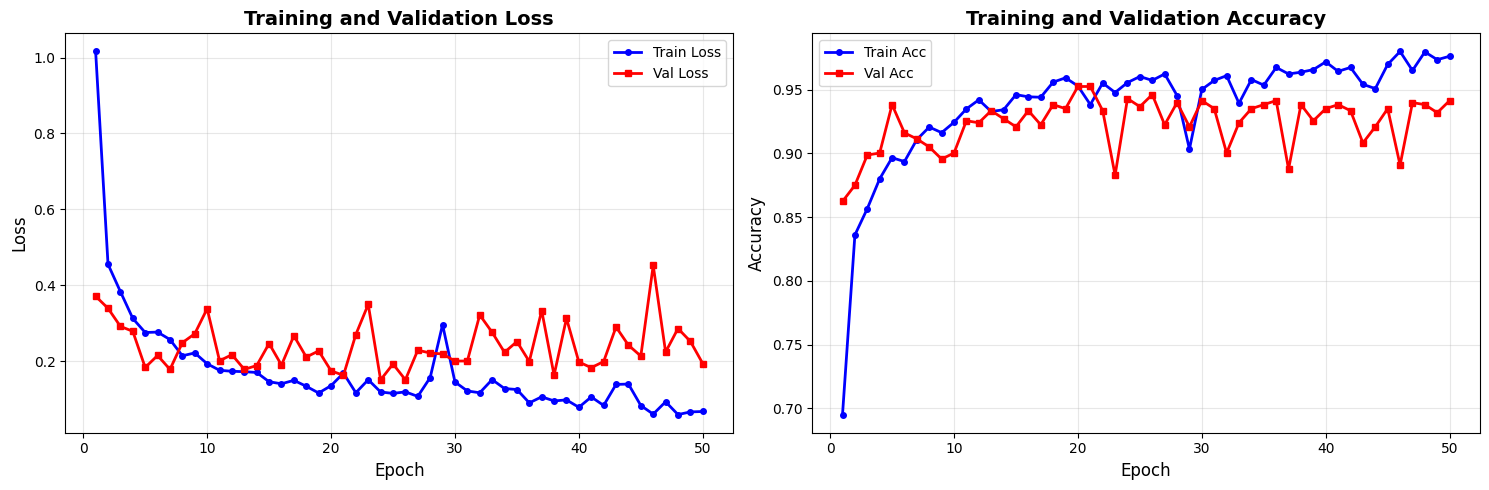


2. Plotting confusion matrix...
Confusion matrix saved as 'efficientnet_confusion_matrix.png'


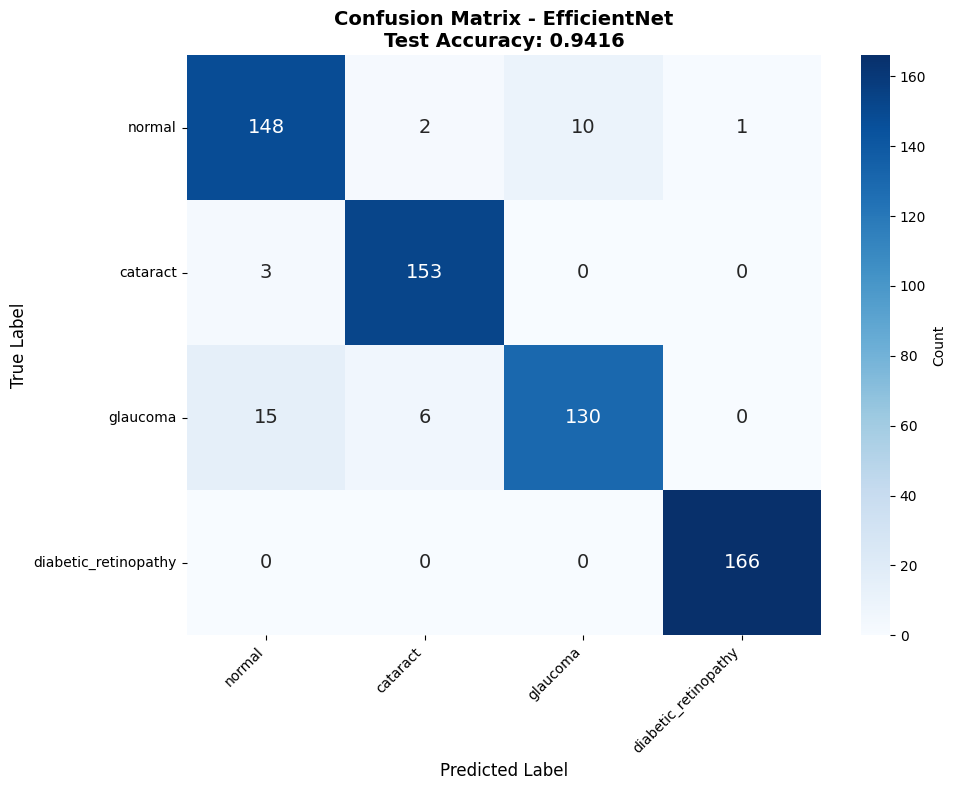


3. Plotting per-class metrics...
Per-class metrics saved as 'efficientnet_per_class_metrics.png'


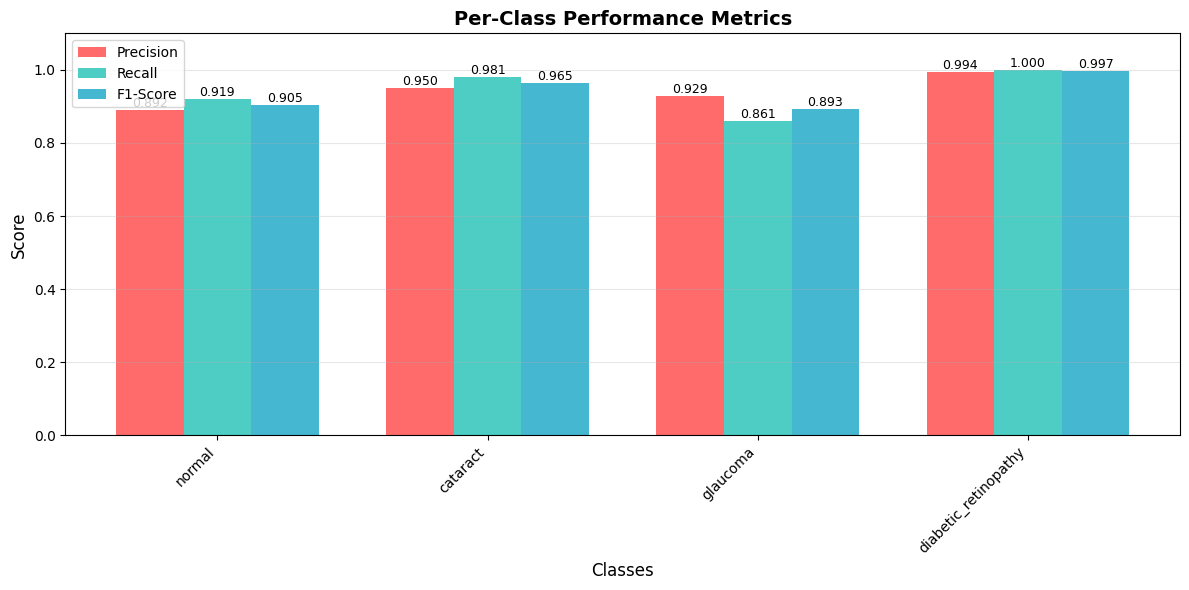


All visualizations generated successfully!


In [32]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Plot 1: Training History
print("\n1. Plotting training history...")
plot_training_history(history)

# Plot 2: Confusion Matrix
print("\n2. Plotting confusion matrix...")
plot_confusion_matrix(cm, accuracy)

# Plot 3: Per-Class Metrics
print("\n3. Plotting per-class metrics...")
plot_per_class_metrics(report_dict)

print("\n" + "="*60)
print("All visualizations generated successfully!")
print("="*60)


## Training Summary and Results
Menampilkan ringkasan lengkap dari training dan evaluation

In [33]:
print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

print(f"\nModel Summary:")
print(f"  Model Architecture:     {EFFICIENTNET_MODEL}")
print(f"  Total Epochs:           {NUM_EPOCHS}")
print(f"  Best Val Accuracy:      {max(history['val_acc']):.4f} ({max(history['val_acc'])*100:.2f}%)")
print(f"  Final Test Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\nPer-Class Performance:")
for cat in CATEGORIES:
    metrics = report_dict[cat]
    print(f"  {cat:25s}: Precision={metrics['precision']:.3f}, "
          f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

print(f"\nGenerated Files:")
print(f"  ✓ efficientnet_eye_disease.pth")
print(f"  ✓ efficientnet_training_history.png")
print(f"  ✓ efficientnet_confusion_matrix.png")
print(f"  ✓ efficientnet_per_class_metrics.png")

print("\n" + "="*60)
print("All tasks completed successfully!")
print("="*60)


TRAINING COMPLETE!

Model Summary:
  Model Architecture:     efficientnet_b3
  Total Epochs:           50
  Best Val Accuracy:      0.9525 (95.25%)
  Final Test Accuracy:    0.9416 (94.16%)

Per-Class Performance:
  normal                   : Precision=0.892, Recall=0.919, F1=0.905
  cataract                 : Precision=0.950, Recall=0.981, F1=0.965
  glaucoma                 : Precision=0.929, Recall=0.861, F1=0.893
  diabetic_retinopathy     : Precision=0.994, Recall=1.000, F1=0.997

Generated Files:
  ✓ efficientnet_eye_disease.pth
  ✓ efficientnet_training_history.png
  ✓ efficientnet_confusion_matrix.png
  ✓ efficientnet_per_class_metrics.png

All tasks completed successfully!
